In [1]:
import os
import sys
import seaborn as sns
import numpy as np
import pandas as pd
if os.path.basename(os.getcwd()) == "vignettes":
    os.chdir("../")

scripts_path = os.path.abspath('.')
sys.path.insert(0, scripts_path)
from pyMethTools.pyMethObj import pyMethObj
np.random.seed(123)

## Simulate some data (15 cpgs spread across 3 regions with 15 samples)

In [2]:
sample_size=50
n_cpg=15
read_depth=50
meth_levels=[0.5,0.05,0.05,0.05,0.5,0.9,0.1,0.1,0.1,0.8, 0.6,0.12,0.13,0.12,0.5]
coverage = np.empty(shape=(n_cpg,sample_size), dtype=int)
meth = np.empty(shape=(n_cpg,sample_size), dtype=int)
for sample in range(0, sample_size):
    n=int(np.random.normal(read_depth,1))
    coverage[:,sample]=np.repeat(n,n_cpg)
    for cpg,k in zip(range(0, n_cpg+1),meth_levels):
        meth[cpg,sample]=np.random.binomial(n, k, 1)[0]
regions = np.repeat([1,2,3], 5)

### Fit the betabinomial models

In [3]:
%%time
obj = pyMethObj(meth,coverage,regions,genomic_positions=np.array(range(200,6600,450)))
obj.fit_betabinom()

CPU times: user 1.55 ms, sys: 774 µs, total: 2.32 ms
Wall time: 1.81 ms


### Find codistributed regions
These are stored in obj.codistrib_regions, there's a value for each cpg, with either cpg number (if not in a codistributed region) 
or the name of the codistributed region a cpg belongs to

In [4]:
%%time
obj.find_codistrib_regions()

CPU times: user 3.89 ms, sys: 1.07 ms, total: 4.95 ms
Wall time: 4.24 ms


In [5]:
obj.codistrib_regions

array(['0', '1_1-3', '1_1-3', '1_1-3', '4', '0', '2_1-3', '2_1-3',
       '2_1-3', '4', '0', '3_1-3', '3_1-3', '3_1-3', '4'], dtype='<U32')

### Plot codistributed regions

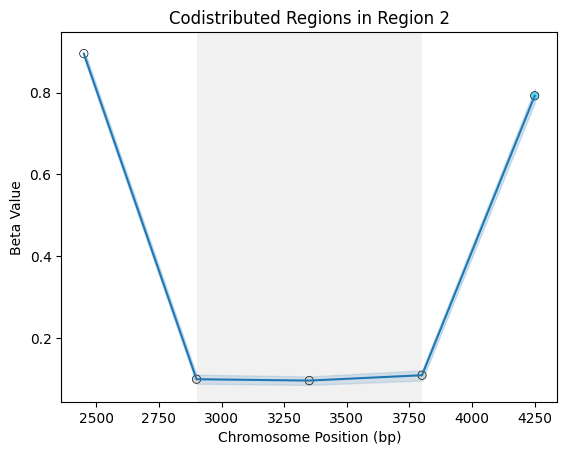

In [6]:
obj.region_plot(2, show_codistrib_regions=True) 

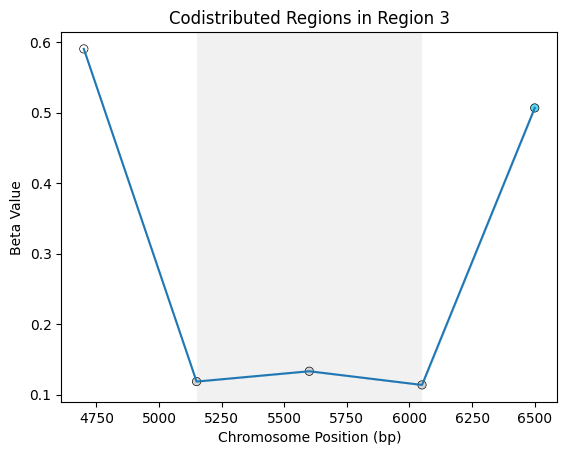

In [7]:
obj.region_plot(3, show_codistrib_regions=True, smooth=True) 

We can see in this simple example we found that the middle three cpgs in each region share similar methylation profiles, but do not with the first and fifth cpg

### Simulating a pertubation
We can also simulate a pertubation to a set of samples, which alters the level of methylation in some of these regions.
This is done by setting adjust factor, which specifies the log2FoldChange of the proportion of reads methylated at a CpG. This adjust factor will be applied to cpgs in n_diff_regions (here 2), with half of the regions experiencing a negative change and half a positive change in the number of reads methylated over their CpGs by default (change the prop_pos paramter to alter this).

In [8]:
sim_meth,sim_coverage,adjust,adjust_regions=obj.sim_multiple_cpgs(sample_size=sample_size,
                                                                  use_codistrib_regions=True,
                                                                  ncpu=1,adjust_factor=0.05,
                                                                  n_diff_regions=[2,0],
                                                                  chunksize=1)
combined_meth=np.concatenate([meth,sim_meth],axis=1)
combined_coverage=np.concatenate([coverage,sim_coverage],axis=1)
beta_vals=combined_meth/combined_coverage

We can see fron the adjust array that cpgs in the codsitributed region in region 2 were increased in methylation, and cpgs in the codsitributed region in region 3 were decreased, which we can also see by plotting out these regions

In [9]:
adjust

array([0.  , 0.05, 0.05, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.05, 0.05, 0.05, 0.  ])

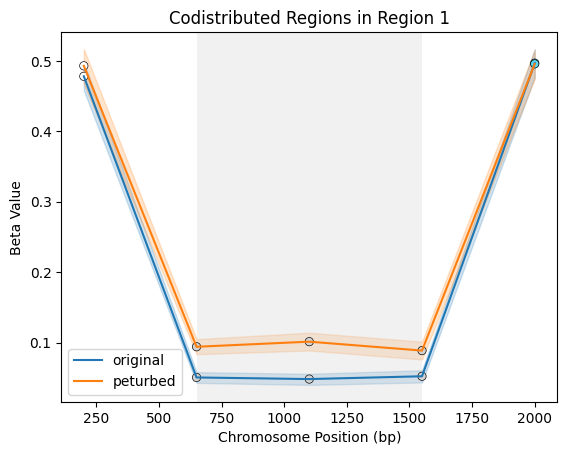

In [10]:
obj.region_plot(1, beta_vals=beta_vals,contrast=np.repeat(["original","peturbed"],sample_size))

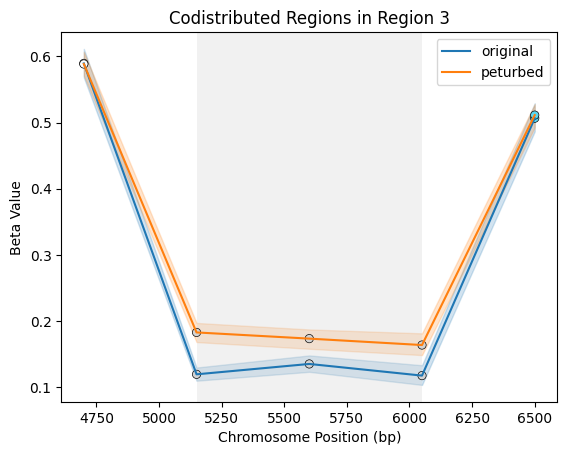

In [11]:
obj.region_plot(3, beta_vals=beta_vals,contrast=np.repeat(["original","peturbed"],sample_size))

### Differential Methylation Analysis
Let's see if we can pick up these pertubations using beta binomial regression

Make a design matrix for proportion of reads methylated (X) and the dispersion of methylation (X_star).
We will include the intercept in both, and with an additional column specifying whether the samples were perterbed in X.

In [12]:
X=np.vstack([np.repeat([0,1],sample_size),np.repeat([0,1,0,1],sample_size/2)]).T
X=pd.DataFrame(X)
X.columns=['group',"timepoint"]
from patsy import dmatrix
X = dmatrix(
            "group + timepoint + group:timepoint",
            data=X,
            return_type='dataframe'
        )
X_star = X.iloc[:,[0]].copy()


In [13]:
X

,Intercept,group,timepoint,group:timepoint
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
95,1.0,1.0,1.0,1.0
96,1.0,1.0,1.0,1.0
97,1.0,1.0,1.0,1.0
98,1.0,1.0,1.0,1.0


In [14]:
X_star

,Intercept
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
95,1.0
96,1.0
97,1.0
98,1.0


Load data, fit the models, and conduct the analysis while finding codistributed and differentially methylated regions, all in 3 lines of code

In [15]:
obj = pyMethObj(combined_meth,combined_coverage,target_regions=regions,genomic_positions=np.array(range(200,6600,450)),covs=X,covs_disp=X_star)
obj.fit_betabinom()
cpg_res,region_res = obj.wald_test(coef="group",find_dmrs="binary_search")
cpg_res

,contrast,stat,pval,fdr,chr,pos
0,group,0.007352,0.994134,0.998547,chr,200
1,group,2.993513,0.002758,0.010342,chr,650
2,group,4.014825,0.000059,0.000446,chr,1100
3,group,3.770778,0.000163,0.000814,chr,1550
4,group,0.273569,0.784416,0.926452,chr,2000
5,group,0.653921,0.513163,0.769744,chr,2450
6,group,-0.764589,0.444516,0.740860,chr,2900
7,group,0.001821,0.998547,0.998547,chr,3350
8,group,1.073811,0.282907,0.606230,chr,3800
9,group,-0.249563,0.802925,0.926452,chr,4250


In [16]:
region_res

,chr,start,end,num_cpgs,num_sig_cpgs,prop_sig_cpgs
0,chr,650,1550,3,3,1.0
1,chr,5150,6050,3,3,1.0


#### We can also find dmrs using a hidden markov model (although this takes longer and is more experimental)

In [17]:
cpg_res,region_res = obj.wald_test("group",find_dmrs="HMM")
region_res

2025-04-27 19:01:32,483	INFO worker.py:1852 -- Started a local Ray instance.


,chr,start,end,num_cpgs,num_sig,state,prop_sig
0,chr,650,1550,3,3,Hypermethylated,1.0
1,chr,5150,6050,3,3,Hypermethylated,1.0


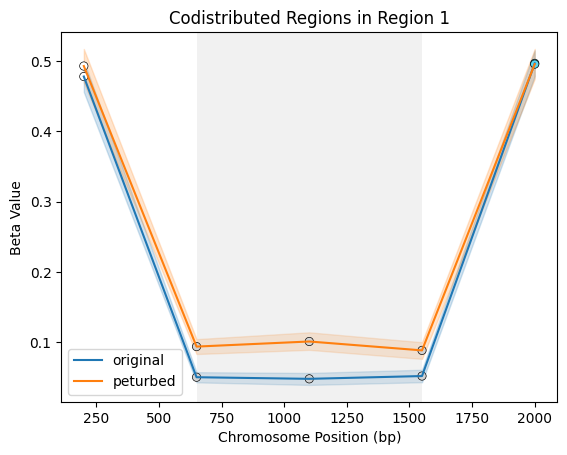

In [18]:
obj.find_codistrib_regions()
obj.region_plot(1, contrast=np.repeat(["original","peturbed"],sample_size))

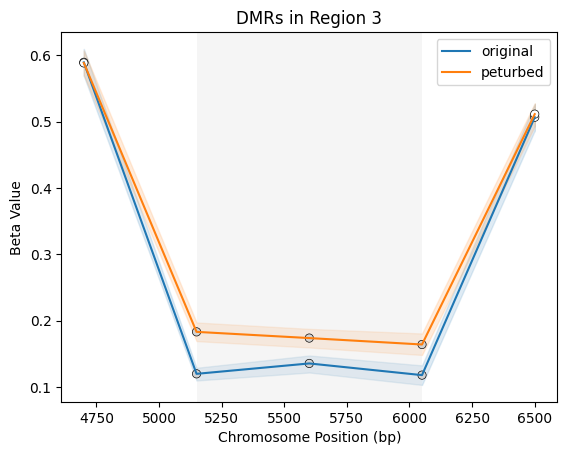

In [19]:
obj.region_plot(3, contrast=np.repeat(["original","peturbed"],sample_size),dmrs=region_res)

#### We can see also that we maintained our codistributed regions, despite the peturbation

In [20]:
obj.codistrib_regions

array(['0', '1_1-3', '1_1-3', '1_1-3', '4', '0', '2_1-3', '2_1-3',
       '2_1-3', '4', '0', '3_1-3', '3_1-3', '3_1-3', '4'], dtype='<U32')

#### We can also test the interaction (we expect this to be null)

In [21]:
cpg_res,region_res = obj.wald_test(coef='group:timepoint',find_dmrs="binary_search")
cpg_res

,contrast,stat,pval,fdr,chr,pos
0,group:timepoint,0.905203,0.365358,0.877031,chr,200
1,group:timepoint,1.601373,0.109294,0.877031,chr,650
2,group:timepoint,1.017397,0.308965,0.877031,chr,1100
3,group:timepoint,-0.632338,0.527166,0.877031,chr,1550
4,group:timepoint,-0.451653,0.651519,0.877031,chr,2000
5,group:timepoint,0.128888,0.897446,0.920769,chr,2450
6,group:timepoint,-0.099465,0.920769,0.920769,chr,2900
7,group:timepoint,-1.003179,0.315775,0.877031,chr,3350
8,group:timepoint,-1.255362,0.209348,0.877031,chr,3800
9,group:timepoint,0.758333,0.448252,0.877031,chr,4250


#### Additionally we can use contrasts to test the effect of group specifically at timepoint 2 (joint of main + interaction) - for this we will use likelihood ratio test, as interaction effects are difficult to assess with the wald test

In [22]:
contrast = {
    "group": 1,
    "group:timepoint": 1
}
cpg_res,region_res = obj.likelihood_ratio_test(contrast=contrast)
cpg_res

,chr,pos,llf_full,llf_reduced,D,df,pval,fdr
0,chr,200,-280.821378,-281.606775,1.570795,2,4.559384e-01,6.880756e-01
1,chr,650,-191.711638,-209.344120,35.264963,2,2.199432e-08,1.099716e-07
2,chr,1100,-200.280947,-220.795900,41.029905,2,1.231599e-09,1.847399e-08
3,chr,1550,-199.985535,-210.572664,21.174257,2,2.523879e-05,9.464546e-05
4,chr,2000,-268.584094,-268.642979,0.117770,2,9.428151e-01,9.428151e-01
5,chr,2450,-208.594127,-209.070284,0.952313,2,6.211663e-01,7.764578e-01
6,chr,2900,-206.995424,-207.697267,1.403686,2,4.956710e-01,6.880756e-01
7,chr,3350,-205.572882,-206.256894,1.368023,2,5.045888e-01,6.880756e-01
8,chr,3800,-221.397263,-222.338326,1.882126,2,3.902129e-01,6.880756e-01
9,chr,4250,-254.333931,-254.600837,0.533812,2,7.657452e-01,8.835522e-01


In [23]:
region_res

,chr,start,end,num_cpgs,num_sig_cpgs,prop_sig_cpgs
0,chr,650,1550,3,3,1.0
1,chr,5150,6050,3,3,1.0


#### We can even simulate new data, including the effects of the covariate (group) we modelled.
We can see the effect of 'group' on the dmr in region 3 is preserved in the simulated data

In [24]:
sample_size_2 = 30
X_sim=np.vstack([np.repeat([0,1],sample_size_2),np.repeat([0,1,0,1],sample_size_2/2)]).T
X_sim=pd.DataFrame(X_sim)
X_sim.columns=['group',"timepoint"]
X_sim = dmatrix(
            "group + timepoint + group:timepoint",
            data=X_sim,
            return_type='dataframe'
        )
X_star_sim = X_sim.iloc[:,[0]].copy()
sim_meth,sim_coverage=obj.sim_multiple_cpgs(X_sim,X_star_sim,sample_size=sample_size_2*2,use_codistrib_regions=True,ncpu=1,adjust_factor=0)

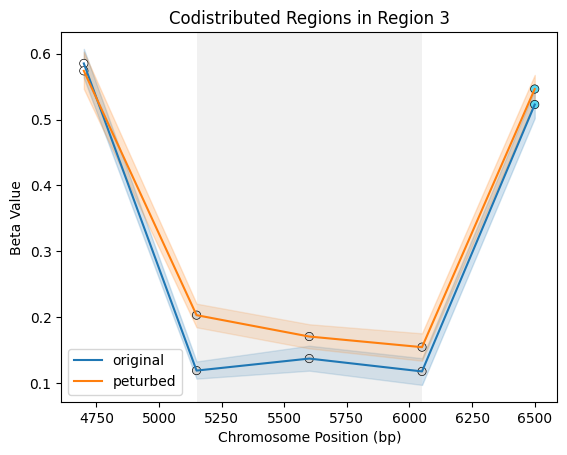

In [25]:
beta_vals_sim = sim_meth/sim_coverage
obj.region_plot(3, beta_vals=beta_vals_sim,contrast=np.repeat(["original","peturbed"],sample_size_2))

We can also see after multiple rounds of simulation our codistributed regions are still preserved 

In [26]:
obj.codistrib_regions

array(['0', '1_1-3', '1_1-3', '1_1-3', '4', '0', '2_1-3', '2_1-3',
       '2_1-3', '4', '0', '3_1-3', '3_1-3', '3_1-3', '4'], dtype='<U32')

## Demonstration of HMM-based DMR finding

In [27]:
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
np.random.seed(42)

# Simulate example differential expression data
n_cpg = 200  # Number of CpGs
positions = np.sort(np.random.randint(1, 100000, size=n_cpg))

# Fake p-values: uniformly distributed between 1e-6 and 1.
epsilon = 1e-6
score1 = np.random.uniform(1e-6, 1.0, size=n_cpg)

# Convert p-values to z-scores:
signs = np.random.choice([-1, 1], size=n_cpg)
score2 = signs * norm.ppf(1 - score1)

# Introduce a hypermethylated block (state 1) from index 50 to 70:
score1[50:71] = np.random.uniform(0.01, 0.001, size=21)  # Reduce pvalue (more significant)
score2[50:71] = 1 * norm.ppf(1 - score1[50:71])  # Convert to test statistic

score1[58] = 0.05  # Increase pvalue of one cpg
score2[58] = norm.ppf(1 - score1[58])  # Convert to test statistic

score1[80:89] = np.random.uniform(0.01, 0.001, size=9) # Increase -log10 pvalue (more significant)
score2[80:89] = 1 * norm.ppf(1 - score1[80:89])  # Convert to test statistic
# Introduce a hypomethylated block (state 2) from index 120 to 140:
score1[120:141] = np.random.uniform(0.01, 0.001, size=21)  # Increase significance
score2[120:141] = -1 * norm.ppf(1 - score1[120:141])  # Convert to negative test statistic

# Create a DataFrame with the required columns.
df_example = pd.DataFrame({
    'chr': 'chr1',
    'pos': positions,
    'pval': score1,
    'fdr': multipletests(score1, method="fdr_bh")[1],
    'stat': score2
})

# Apply the HMM-based segmentation.
regions_found = obj.find_significant_regions_HMM(df_example, n_states=3, min_cpgs=3, hmm_plots=True, hmm_internals=True)
print("Candidate DMR regions:")
print(regions_found)

2025-04-27 19:01:35,927	INFO worker.py:1852 -- Started a local Ray instance.
(process_chromosome pid=55734) Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


(process_chromosome pid=55734) hmm state means:
(process_chromosome pid=55734)  [[ 0.43313728 -0.04888808]
(process_chromosome pid=55734)  [ 2.28212371  2.54783561]
(process_chromosome pid=55734)  [ 2.35926831 -2.61100903]]
(process_chromosome pid=55734) hmm state transition probabilities:
(process_chromosome pid=55734)  [[9.52473170e-01 2.11014459e-02 2.64253846e-02]
(process_chromosome pid=55734)  [9.84704723e-02 9.01529528e-01 1.84512545e-69]
(process_chromosome pid=55734)  [1.60150894e-01 1.75439688e-45 8.39849106e-01]]
Candidate DMR regions:
    chr  start    end  num_cpgs  num_sig            state  prop_sig
0  chr1  24301  38045        21       20  Hypermethylated  0.952381
1  chr1  42942  48926         9        9  Hypermethylated  1.000000
2  chr1  64506  71212        21       21   Hypomethylated  1.000000
